# Realtime Pothole Detection using Computer Vision

## Problem Statement:


Road transport is one of the major modes of transport, it plays a crucial role
in economic development of a country by connecting communities and
businesses, by providing access to education, employment, social, and
health services. Roads are damaged by several reasons such as weather,
high traffic load, heavy vehicles, construction techniques, construction
materials and lack of maintenance of roads. Among several road
damages/defects, potholes are most annoying, it causes discomfort to
travellers, damages to vehicles and accidents.  
In this case study we build a real time pothole detection system using
computer vision technique, which assist the driver for safe and comfortable
driving experience

## DL Formulation:


This is an Object detection problem, create a dataset by capturing the road
images, annotate the images by drawing a bounding box around them. Train
an Object detection model such that given an input image, identify/classify
as a pothole or not and if it contains a pothole localize it by drawing a
bounding box around it in realtime.

## Performance Metrics:

* Mean Average Precision
* Intersection Over Union (IOU)

## Data Overview:

Data is collected from [kaggle](https://www.kaggle.com/sovitrath/road-pothole-images-for-pothole-detection), S. Nienaber, M.J. Booysen, and R.S. Kroon created
the dataset and open sourced it. Data is collected by mounting a GoPro camera on the
front windscreen of a car, moving with a speed of 40km/h. To avoid the blurring, images
are captured with a time lapse of 0.5 sec

In [69]:
# Importing libraries

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import cv2

In [70]:
data_dir = 'data/Dataset 1 (Simplex)/Dataset 1 (Simplex)' # data directory

# printing all the folders/files within the data directory
print(os.listdir(data_dir))

['Test data', 'train_df.csv', 'Train data', 'simpleTrainFullPhotosSortedFullAnnotations.txt', 'simpleTestFullSizeAllPotholesSortedFullAnnotation.txt', 'PotholeDataset.pdf']


In [71]:

def get_file_path_df(folder):
  """
  Function to get path of .jpg files in the specified folder
  takes folder input and returns pandas dataframe
  """
  image_path = [] 
  for root, dirs, files in os.walk(folder):
    for f in files:
      if f.endswith(".JPG"): # checking for JPG extension 
        image_path.append(os.path.join(root, f)) # appending to image_path list
   # df = dataframe
  df_cols = {'path': image_path} # creating a dictionary
  df = pd.DataFrame(df_cols) # creating a dataframe
  return df





In [72]:
# getting absolute path of all images and storing in a dataframe called data_df
data_df = get_file_path_df(data_dir)

# displying random 5 rows
data_df.head()

path
0  data/Dataset 1 (Simplex)/Dataset 1 (Simplex)/T...
1  data/Dataset 1 (Simplex)/Dataset 1 (Simplex)/T...
2  data/Dataset 1 (Simplex)/Dataset 1 (Simplex)/T...
3  data/Dataset 1 (Simplex)/Dataset 1 (Simplex)/T...
4  data/Dataset 1 (Simplex)/Dataset 1 (Simplex)/T...

In [73]:
data_df.shape

(4405, 1)

### Observations:
* Data contains 4405 images

In [ ]:
for class_name in os.listdir(data_dir):
    for path in os.listdir(data_dir+"/"+class_name):

        data_dir.append(os.path.join(DIRECTORY, class_name, path))
print(data_dir[0], label[0])




In [75]:
# creating train, validation and test dataframe
train_df, test_df = get_train_test_df(data_df)

In [ ]:
# train dataframe

train_df.sample(5)


In [77]:
# test dataframe
test_df.sample(5)
test_df.size

4405

## EDA:

### Data distribution

In [ ]:
# visualization of data distribution among train and test

# creating a bar plot
plot = sns.barplot(['Train', 'Test'], 
                   [train_df.shape[0], test_df.shape[0]])
plt.title('Data Distribution')
plt.xlabel('Dataset')
plt.ylabel('Count')

# adding class count to the barplot
for patch in plot.patches:
    # formatting and positioning the count values
    plot.annotate('{:n}'.format(patch.get_height()), 
                  (patch.get_x()+0.25, patch.get_height()+1)) 
plt.show()

#### Observations:
* Data contains 3777 training images
* Data contains 628 test images

### Class distribution

In [ ]:
def get_class_distrib(df):
  """
  Function to get class distribution within a dataset
  takes dataframe input and plots the class distribtution
  """
  label_count = df['label'].value_counts()
  plot = sns.barplot(list(label_count.index), list(label_count.values))
  plt.title('Class Distribution')
  plt.xlabel('Class Label')
  plt.ylabel('Count')

  # adding class count to the barplot
  for patch in plot.patches:
      # formatting and positioning the count values
      plot.annotate('{:n}'.format(patch.get_height()), 
                    (patch.get_x()+0.25, patch.get_height()+1)) 
  plt.show()


Class distribution of training data


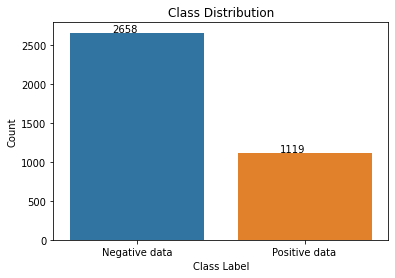

In [ ]:
print("Class distribution of training data")
get_class_distrib(train_df)

### Observations:
* Data contains 1119 images with potholes
* Data contains 2658 images without potholes

### Image height & width distribution

In [ ]:
def get_image_size_distrib(df):
  """
  function to get distribution of image height and width
  takes datafame input
  outputs mean and median value of height and width
  """
  
  heights = []
  widths = []

  for path in df['path'].values:
          # img = cv2.imread(os.path.join(img_dir, path))
          img = cv2.imread(path) 
          shape = img.shape # (h, w, d) = image.shape
          heights.append(shape[0])
          widths.append(shape[1]) 

  plt.figure(figsize=(10,3))
  sns.distplot(heights)
  plt.title('Image height distribution')
  plt.xlabel('Height')
  plt.show()
  height_median = np.median(heights)
  print('Median height:', height_median)
  height_mean = np.mean(heights)
  print('Mean height:', height_mean)
  print()
  plt.figure(figsize=(10,3))
  sns.distplot(widths)
  plt.title('Image width distribution')
  plt.xlabel('Width')
  plt.show()
  width_median = np.median(widths)
  print('Median width:', width_median)
  width_mean = np.mean(widths)
  print('Mean width:', width_mean)


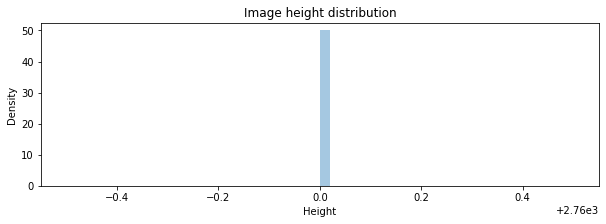

Median height: 2760.0
Mean height: 2760.0



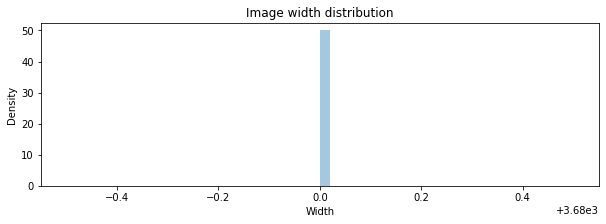

Median width: 3680.0
Mean width: 3680.0


In [ ]:
get_image_size_distrib(data_df)

#### Obsesrvations:
* All the images are of same size
* image height = 2760 pixel
* image width = 3680 pixel


### Image Annotations (Bounding Box)

In [ ]:
# annotation data (bounding boxes)

annotation_df = pd.read_csv(os.path.join(data_dir, 'train_df.csv'))
annotation_df.head()

image_id  num_potholes     x     y    w   h
0  G0010033             6  1990  1406   66  14
1  G0010033             6  1464  1442   92  16
2  G0010033             6  1108  1450   54  16
3  G0010033             6   558  1434  102  16
4  G0010033             6   338  1450   72  18

### Observations:
* column details:
    * num_potholes: number of the potholes in an image
    * x: upper left corner coordinate
    * y: upper left corner coordinate
    * w: width of the pothole
    * h: height of the pothole

### Visualizing the data

In [ ]:
def visualize_data(img_df, annot_df, data_type):
  """
  Function to visualize images
  takes image dataframe, BBox dataframe and datatype input
  if data_type is test then print images without label else print with labels
  and BBoxes
  """
  
  rows = np.random.randint(img_df.shape[0], size=5) # generating 5 random numbers
  sample_imgs = img_df.iloc[rows, :] # random images

  counter = 0
  plt.figure(figsize = (12, 50))

  # checking if lowercase data_type = test
  if data_type.lower() == 'test':
      for idx, row in sample_imgs.iterrows():
        path = row['path'] # file path
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED) # reading the image
        plt.subplot(5, 1, 1 + counter)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        counter += 1
  else:
      for idx, row in sample_imgs.iterrows():
        # file path
        path = row['path']  #(data/Train data/Positive data/G0027850.JPG
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED) # reading the image
        lab = row['label'] # file label
        coords = [] # BBox coordinates
        # if the image contains potholes
        if lab == 'Positive data':
          lab = 'Pothole'
          img_id = path.split('/')[-1]
          img_id = img_id.split('.')[0]
          coords = annot_df[annot_df['image_id'] == img_id]
          coords = coords[['x', 'y', 'w', 'h']].values
        else:
          lab = 'No Pothole' 

        plt.subplot(5, 1, 1 + counter)
        plt.title(lab)
        plt.xticks([])
        plt.yticks([])
        # drawing BBoxes
        for c in coords:
          cv2.rectangle(img, (c[0], c[1]), (c[0]+c[2], 
                            c[1]+c[3]), (255, 0, 0), 3)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        counter += 1
  plt.show()

#### Training data

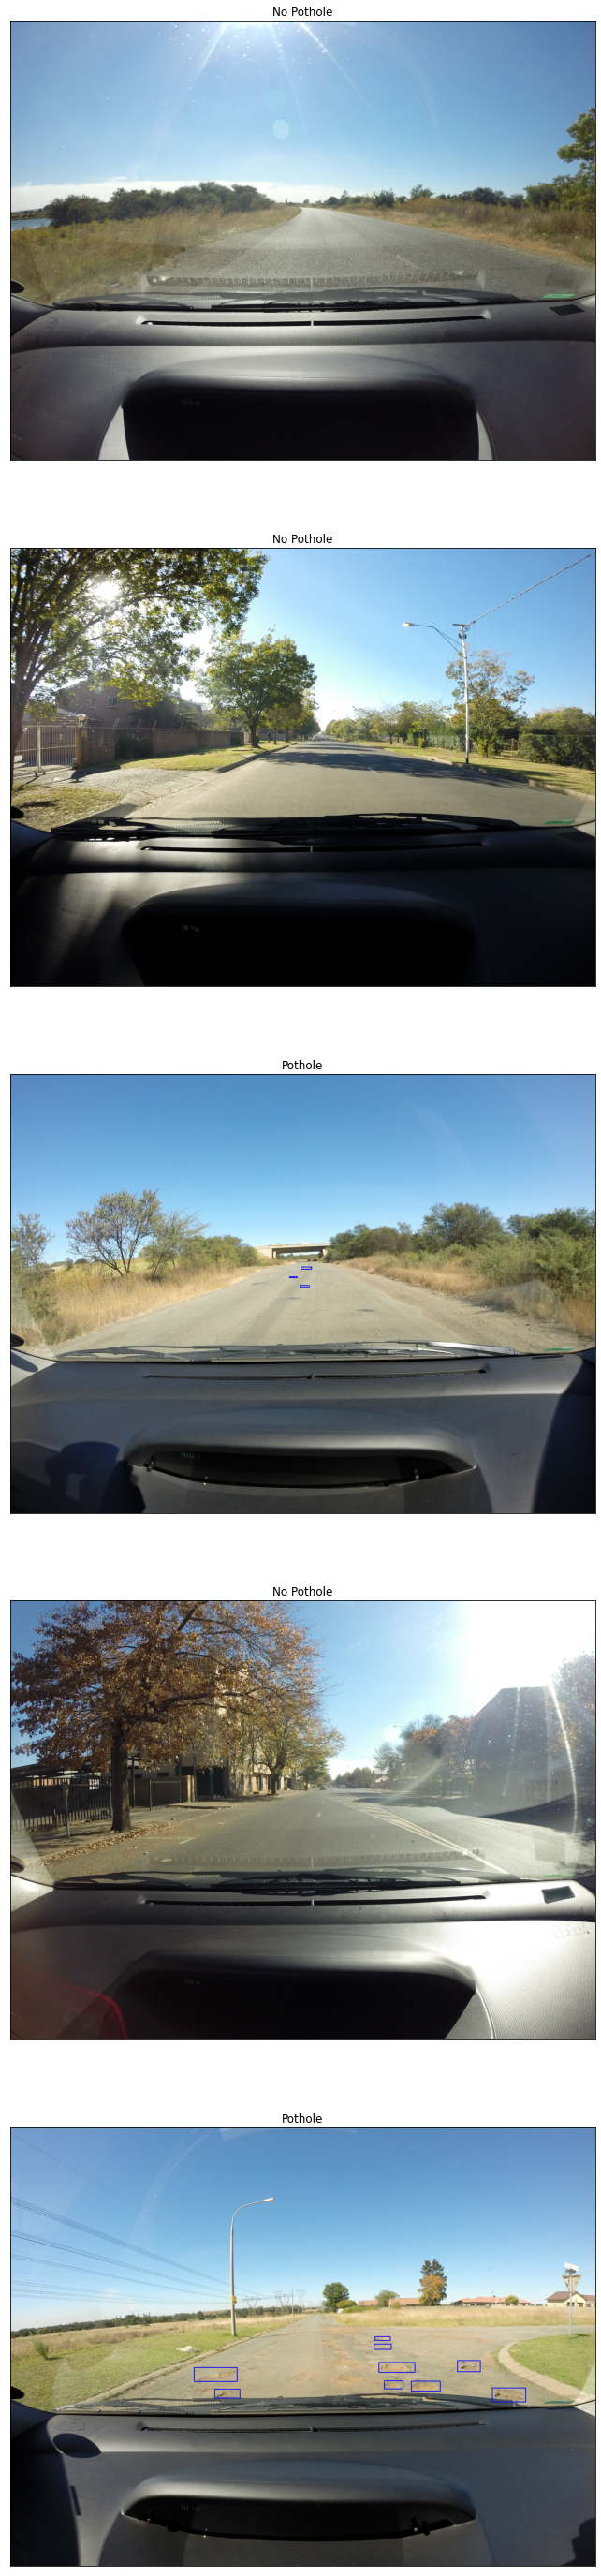

In [ ]:
# visualizing train data
visualize_data(train_df, annotation_df, 'Train')

#### Test data

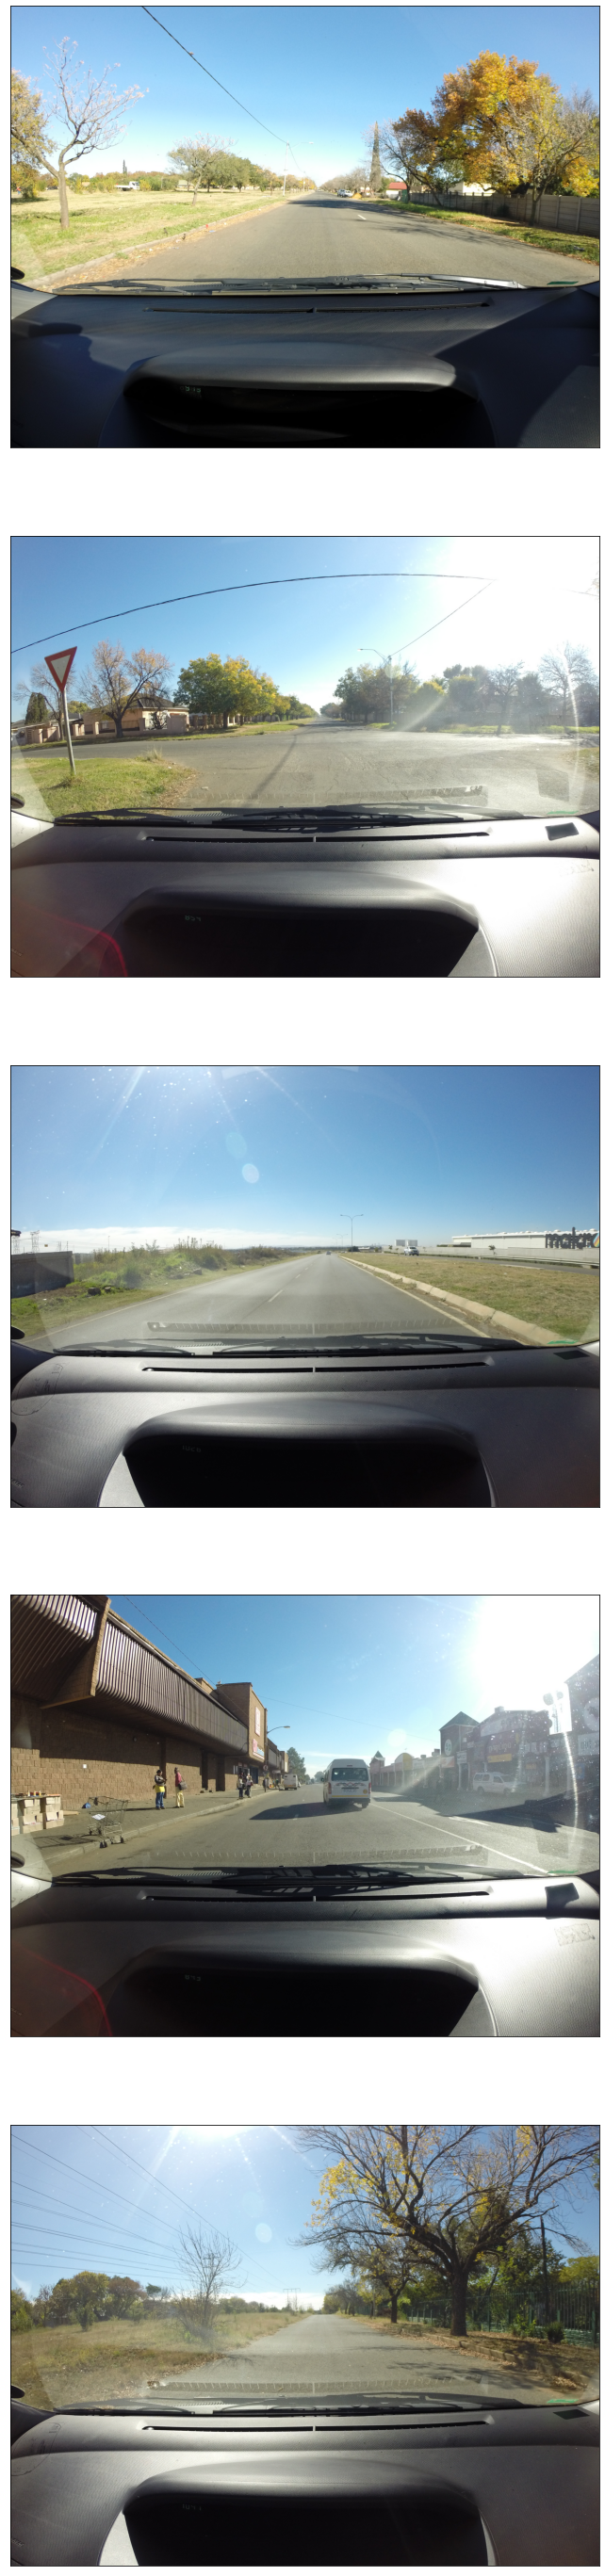

In [ ]:
# visualizing test data
visualize_data(train_df, annotation_df, 'Test')

### EDA Summary:


* Data contains 4405 images, in which 3777 images belong to training set and 628 images belong to test set
* Training data contains 2 classes namely Positive (pothole) and Negative (No pothole)
* 1119 training images belong to positive class and 2658 images belong to negative class
* All the images are of same size with height 2760 pixel and width 3680 pixel